In [ ]:
# unzipping böyle yapılıyor ve data klasor'ünün altında
# cats_and_dogs -> data yaptım

#!unzip cats_and_dogs.zip


In [ ]:
# deleting folders.
# %rm -rf <data> # işe yaramıyor silmiyor

In [4]:
# 2.jpg
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2,itertools
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix


In [17]:
# 2.jpg
train_dir = "data/train"
val_dir = 'data/validation'
train_images = glob(train_dir+'/*/*.jpg')
val_images = glob(val_dir+'/*/*.jpg')
# /*/*.jpg nin olayı budur hoca dedi
# Val_dir içinde iki tane klasör var,
# Buradaki ilk yıldız tüm klasörleri al diyoruz,
# Sonra / bu işaret bu klasörün içine gir demek,
# Sonra da *.jpg var,Bu da .jpg uzantılı tüm dosyaları al demek,
# Bu arada ilk yıldızın önündeki / ile val_dir’in içine giriyoruz


In [18]:
# 2.jpg
# burada train kasörü içindeki dosyaların dizinini alıyoruz
# yani klasor sayısı kadar sınıf var
d = glob(train_dir+'/*')
# listenin uzunlugunu buluyoruz,yani kaç tane klasor oldugunu
# bu da sınıf sayısına eşittir.
o = len(d)

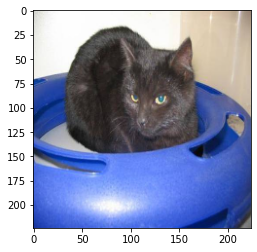

In [19]:
# 2.jpg
# her kod her seferinde rastgele bir resim gösterir
image_name=np.random.choice(train_images)
img = cv2.imread(image_name)
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [20]:
# 3.jpg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# burada data augmentation yani veri cogaltma yapıyoruz
# veriler yuklenirken verilere ek islem uygulanıyor
# ornegin burada horizontal_flip=True denmiş.bu sayede resmin yatay cevirilmiş halini de kullanıyoruz
# rescale 1.0/255, bu ise resmi 0 ile 1 arasına dönüstürüyoruz ,normalde image'ler 0 ile 255 arasında her sey olabilir ,0=black,1=white
# rotation_range=40, resmi 40 derece rastgele döndür
# width_shift_range=0.2, resmi yatayda yüzde 20 oranında kaydır
# height_shift_range=0.2, resmi dikeyde yüzde 20 oranında kaydır
# shear_range=0.2, resmi yüzde 20 oranında kırp
# zoom_range=0.2, resme yüzde 20 oranında yaklas ve uzaklas
# fill_mode='nearest', yeni olusacak piksellere deger atarken en yakınındaki pikselleri kullan demek
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# bunu dogrulama verileri için yapmayız,egitim verileri için yaparız
# bu sayede hem egitim verisini arttırıp hem de ceşitlendiririz.
# bu sayede model daha iyi ögrenebilir
val_datagen = ImageDataGenerator( rescale = 1.0/255. )


In [21]:
# 4.jpg
# burada ikiden fazla sınıf oldugu için class_mode = sparse oldu
train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size=16,
    target_size=[224,224],
    class_mode='sparse')

valid_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=16,
    target_size=[224,224],
    class_mode='sparse')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
# 4.jpg
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model=VGG16(
  input_shape=[224,224,3],weights='imagenet',include_top=False)
for layer in vgg_model.layers:
  layer.trainable=False
fl =Flatten()(vgg_model.output)
x = Dense(1024,activation='relu')(fl)
x = Dropout(0.2)(x)
# son katmandaki nöron sayısı sınıf sayısı kadar olmalı
# normalde bunu elle yazabiliriz fakat sınıf sayısını bulup bu sekilde yapmak daha iyidir
out = Dense(o,activation='softmax')(x)
model = Model(inputs=vgg_model.input,outputs=out)


58900480/58889256 [==============================] - 0s 0us/step


In [23]:
# 4.jpg
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# 5.jpg
r=model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=1 # epochs=10 yaptı ama uzun olur diye 1,2 felan yapmakda fayda var
) 

125/125 [==============================] - 1765s 14s/step - loss: 1.3749 - accuracy: 0.7280 - val_loss: 0.2670 - val_accuracy: 0.8930


In [27]:
# 5.jpg
model.evaluate(valid_generator)

63/63 [==============================] - 533s 8s/step - loss: 0.2670 - accuracy: 0.8930


[0.26696768403053284, 0.8930000066757202]

In [ ]:
# 5.jpg
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
# 5.jpg
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

In [ ]:
# 5.jpg
# burada etiket adlarını buluyoruz.bunun için val_datagen kullanıyoruz
# train_datagen ise olmaz,cünkü orada data augmentation yaptık
# o yüzden onu kullanmaya gerek yok
test_gen = val_datagen.flow_from_directory(val_dir,target_size=[224,224])
# burada etiketleri(sınıfları) yazdırıyoruz.Ayrıca hangi etikete hangi sayının atandıgı da gözüküyor
print(test_gen.class_indices)
# burada bos bir liste olusturuyoruz eleman sayısı ise etiket sayısı kadar
labels =[None] * len(test_gen.class_indices)
# burada v indis, k ise etiket
i=0
for k,v in test_gen.class_indices.items():
  # sırayla etiketleri bu listeye ekliyoruz
  labels[v] = k
  print("labels[",v,"] :",labels[v]," and k :",k) # merak ettim ne vericek diye,
  # şimdi her bir fotonun karsısına cats veya dogs veriyor.
  if i!=5:
    i=i+1
    continue
  break
# bu islem kendimiz etiketleri labels'in içine yazabiliriz
# ama burada sıra önemli dogru sırayı bulamayabiliriz. 
#  kendicem if i!=5: felan ekledim ne veriyor görmek için bu alttakileri verdi
# Found 1000 images belonging to 2 classes.
# {'cats': 0, 'dogs': 1}
# labels[ 0 ] : cats  and k : cats
# labels[ 1 ] : dogs  and k : dogs

In [42]:
# 6.jpg
# burada confusion matrix olusturmak için bir fonksiyon yazıyoruz.
batch_size=16
IMAGE_SIZE=[224,224]
def get_confusion_matrix(data_path,N):
  print("Generating confusion matrix",N)
  predictions = []
  targets = []
  i=0
  n_images=0
  for x,y in val_datagen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i+=1
    n_images+=len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p,axis=1)
    y = np.argmax(y,axis=1)
    predictions =np.concatenate((predictions,p))
    targets = np.concatenate((targets,y))
    if len(targets) >= N:
      break
  cm = confusion_matrix(targets,predictions)
  return cm



In [ ]:
# 7.jpg

# burada confusion matrix buluyoruz,bu modelin veriler için yaptıgı tahminleri ve kacının
# dogru oldugunu gösterir.ornegin modelin tahmini 1.sınıf iken
# gercekte 0.sınıf olan kac veri oldugunu soyler,
# burada kosegenler dogru tahmindir,o yüzden kosegenlerdeki sayıların
#  yuksek olması lazım basarılı bir model için

cm = get_confusion_matrix(val_dir,len(val_images))
print(cm)
# output :
# Generating confusion matrix 1000
# Found 1000 images belonging to 2 classes.
# [[433  67]
#  [ 40 460]]

In [48]:
# 8.jpg
# burada confusion matrix'i görsellestiriyoruz
# kodu anlamaya fazla gerek yok,zaten gorsellestirme kodu ve genelde hazır kullanılır bu kod
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix,without normalization")
  print(cm)

  plt.figure(figsize=(15,15))
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()



In [ ]:
# 9.jpg
# yukardaki fonksiyon olusturmustuk burada cagıracagız
plot_confusion_matrix(cm,labels,title='Validation confusion matrix')

cat=0 and dogs=1 dur,indis :  0
Gercek etiker :  data/validation/cats/cat.2412.jpg
modelin tahmini :  cats


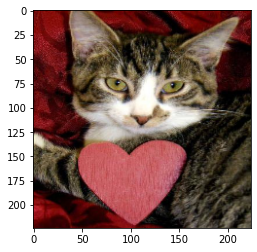

In [59]:
# 9.jpg
# burada rastegele bir dogrulama resmi secip modele bunu tahmin ettirip resmi cizdiriyoruz
# burada lsiteden rastgele bir resim dizini aldık
pred_image_name =np.random.choice(val_images)
# bu rastgele dizini kullanarak rastgele bir resim yükledik
img =cv2.imread(pred_image_name)
# resmi modele uygun boyuta getirdik
img=cv2.resize(img,(224,224))
# opencvdeki resimleri bgr uzayında  bunu rgb uzayını dönüştürdük
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# modele verilecek resim 4 boyutlu olmalı
# bu boyut batch size'i temsil ediyor
# burada resme ekstra bir boyut ekledik
tensor_image =np.expand_dims(img,axis=0)
# modele tahmin yaptırdık
prediction =model.predict(tensor_image)
# bu tahminden en yüksek degere sahip sınıfın indisini aldık
prediction1=np.argmax(prediction)
print("cat=0 and dogs=1 dur,indis : ",prediction1) # bu indis bize 0 yada 1  veriyor ,yani cats or dogs, 2 class var ya,yada 2 label var cats and dogs 
# tahminin hangi etikete ait oldugunu ögrendik
tahmin=labels[prediction1]
# resmin indisini yazıyoruz,burası karısık olsada hangi sınıfa ait oldugunu da yazıyor
print('Gercek etiker : ',pred_image_name)
# modelin hangi etiketi tahmi ettigini yazdırıyoruz
print("modelin tahmini : ",tahmin)
plt.imshow(img)
